In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
import warnings
warnings.filterwarnings('ignore')

![alt text](mindmap.png "Title")

# Préprocessing
| Column name | Column type | Use default transformation ? | Cleaning method | Possible values | Is Label ? |
|------|------|------|------|------|------|
| Class | Boolean | Yes | Replace value by : False | True value = recurrence-events / False value = no-recurrence-events | No |
| age | Ordinal Qualitative | Yes | Delete Line | 10-19 / 20-29 / 30-39 / 40-49 / 50-59 / 60-69 / 70-79 / 80-89 / 90-99 | No |
| menopause | Nominal Qualitative | Yes | Delete Line | lt40 / ge40 / premeno | No |
| tumor_size | Ordinal Qualitative | Yes | Delete Line | 0-4 / 5-9 / 10-14 / 15-19 / 20-24 / 25-29 / 30-34 / 35-39 / 40-44 / 45-49 / 50-54 / 55-59 | No |
| inv_nodes | Ordinal Qualitative | Yes | Delete Line | 0-2 / 3-5 / 6-8 / 9-11 / 12-14 / 15-17 / 18-20 / 21-23 / 24-26 / 27-29 / 30-32 / 33-35 / 36-39 | No |
| node_caps | Boolean | Yes | Delete Line | True value = yes / False value = no | No |
| deg-malig | Quantitative Discrete | Yes | Delete Line |  | No |
| breast | Nominal Qualitative | Yes | Delete Line | left / right | No |
| breast-quad | Nominal Qualitative | Yes | Delete Line | left_up / left_low / right_up / right_low / central | No |
| irradiat | Boolean | Yes | Delete Line | True value = yes / False value = no | Yes |


## We import the dataset

In [3]:
def load_dataset() -> pd.DataFrame: 
	current_dataset = pd.read_csv("./breast-cancer.csv", header=None) 
	current_dataset.columns = ['Class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat'] 
	return current_dataset 

dataframe: pd.DataFrame = load_dataset() 
dataframe

,Class,age,menopause,tumor_size,inv_nodes,node_caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [4]:
def clean_dataset(dataframe: pd.DataFrame) -> pd.DataFrame:
	dataframe = dataframe.replace("?", np.nan)
	dataframe["Class"] = dataframe["Class"].replace(np.nan, False)
	dataframe = dataframe[dataframe["age"].notna()]
	dataframe = dataframe[dataframe["menopause"].notna()]
	dataframe = dataframe[dataframe["tumor_size"].notna()]
	dataframe = dataframe[dataframe["inv_nodes"].notna()]
	dataframe = dataframe[dataframe["node_caps"].notna()]
	dataframe = dataframe[dataframe["deg-malig"].notna()]
	dataframe = dataframe[dataframe["breast"].notna()]
	dataframe = dataframe[dataframe["breast-quad"].notna()]
	dataframe = dataframe[dataframe["irradiat"].notna()]
	return dataframe.reset_index(drop=True)

dataframe: pd.DataFrame = load_dataset()

cleaned_dataframe = clean_dataset(dataframe)
cleaned_dataframe


,Class,age,menopause,tumor_size,inv_nodes,node_caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
272,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
273,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
274,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
275,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


# Splitting

In [5]:
def split_data(dataframe: pd.DataFrame):
	y = dataframe["irradiat"]
	X = dataframe.drop("irradiat", axis=1)
	
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
	
	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
	
	return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_val.reset_index(drop=True), y_val.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

dataframe: pd.DataFrame = load_dataset()

cleaned_dataframe = clean_dataset(dataframe)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(cleaned_dataframe)
X_train, y_train, X_val, y_val, X_test, y_test

(                    Class    age menopause tumor_size inv_nodes node_caps  \
 0    no-recurrence-events  40-49   premeno      30-34       0-2        no   
 1    no-recurrence-events  50-59      ge40      10-14       0-2        no   
 2       recurrence-events  40-49   premeno      25-29       0-2        no   
 3    no-recurrence-events  50-59   premeno      25-29       3-5       yes   
 4    no-recurrence-events  50-59      ge40      35-39       0-2        no   
 ..                    ...    ...       ...        ...       ...       ...   
 194  no-recurrence-events  50-59   premeno      20-24       3-5       yes   
 195     recurrence-events  30-39   premeno      35-39       0-2        no   
 196  no-recurrence-events  30-39   premeno      30-34       0-2        no   
 197     recurrence-events  50-59      ge40      30-34       6-8       yes   
 198  no-recurrence-events  40-49   premeno      10-14       0-2        no   
 
      deg-malig breast breast-quad  
 0            1  right   

# Transformation

In [6]:
def transform_data(X_train, X_val, X_test):
	X_train["Class"] = X_train["Class"].map({'recurrence-events': True, 'no-recurrence-events': False})
	X_val["Class"] = X_val["Class"].map({'recurrence-events': True, 'no-recurrence-events': False})
	X_test["Class"] = X_test["Class"].map({'recurrence-events': True, 'no-recurrence-events': False})
	
	ordinal_encoder = OrdinalEncoder(categories=[['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']])
	X_train["age"] = ordinal_encoder.fit_transform(X_train[["age"]])
	X_val["age"] = ordinal_encoder.fit_transform(X_val[["age"]])
	X_test["age"] = ordinal_encoder.fit_transform(X_test[["age"]])
	
	one_hot_encoder = OneHotEncoder( categories=[['lt40', 'ge40', 'premeno']])
	X_train_encoded_values = one_hot_encoder.fit_transform(X_train[["menopause"]]).toarray()
	X_val_encoded_values = one_hot_encoder.fit_transform(X_val[["menopause"]]).toarray()
	X_test_encoded_values = one_hot_encoder.fit_transform(X_test[["menopause"]]).toarray()
	
	
	X_train_encoded = pd.DataFrame(X_train_encoded_values, columns=[f"menopause_{x}" for x in one_hot_encoder.categories_[0]])
	X_val_encoded = pd.DataFrame(X_val_encoded_values, columns=[f"menopause_{x}" for x in one_hot_encoder.categories_[0]])
	X_test_encoded = pd.DataFrame(X_test_encoded_values, columns=[f"menopause_{x}" for x in one_hot_encoder.categories_[0]])
	X_train = X_train.join(X_train_encoded)
	X_val = X_val.join(X_val_encoded)
	X_test = X_test.join(X_test_encoded)
	
	X_train = X_train.drop("menopause", axis=1)
	X_val = X_val.drop("menopause", axis=1)
	X_test = X_test.drop("menopause", axis=1)
	ordinal_encoder = OrdinalEncoder(categories=[['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']])
	X_train["tumor_size"] = ordinal_encoder.fit_transform(X_train[["tumor_size"]])
	X_val["tumor_size"] = ordinal_encoder.fit_transform(X_val[["tumor_size"]])
	X_test["tumor_size"] = ordinal_encoder.fit_transform(X_test[["tumor_size"]])
	
	ordinal_encoder = OrdinalEncoder(categories=[['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39']])
	X_train["inv_nodes"] = ordinal_encoder.fit_transform(X_train[["inv_nodes"]])
	X_val["inv_nodes"] = ordinal_encoder.fit_transform(X_val[["inv_nodes"]])
	X_test["inv_nodes"] = ordinal_encoder.fit_transform(X_test[["inv_nodes"]])
	
	X_train["node_caps"] = X_train["node_caps"].map({'yes': True, 'no': False})
	X_val["node_caps"] = X_val["node_caps"].map({'yes': True, 'no': False})
	X_test["node_caps"] = X_test["node_caps"].map({'yes': True, 'no': False})
	
	X_train["deg-malig"] = X_train["deg-malig"].astype(float) 
	X_val["deg-malig"] = X_val["deg-malig"].astype(float) 
	X_test["deg-malig"] = X_test["deg-malig"].astype(float) 
	X_train[["deg-malig"]] = minmax_scale(X_train[["deg-malig"]]) 
	X_val[["deg-malig"]] = minmax_scale(X_val[["deg-malig"]])
	X_test[["deg-malig"]] = minmax_scale(X_test[["deg-malig"]])
	
	one_hot_encoder = OneHotEncoder( categories=[['left', 'right']])
	X_train_encoded_values = one_hot_encoder.fit_transform(X_train[["breast"]]).toarray()
	X_val_encoded_values = one_hot_encoder.fit_transform(X_val[["breast"]]).toarray()
	X_test_encoded_values = one_hot_encoder.fit_transform(X_test[["breast"]]).toarray()
	
	
	X_train_encoded = pd.DataFrame(X_train_encoded_values, columns=[f"breast_{x}" for x in one_hot_encoder.categories_[0]])
	X_val_encoded = pd.DataFrame(X_val_encoded_values, columns=[f"breast_{x}" for x in one_hot_encoder.categories_[0]])
	X_test_encoded = pd.DataFrame(X_test_encoded_values, columns=[f"breast_{x}" for x in one_hot_encoder.categories_[0]])
	X_train = X_train.join(X_train_encoded)
	X_val = X_val.join(X_val_encoded)
	X_test = X_test.join(X_test_encoded)
	
	X_train = X_train.drop("breast", axis=1)
	X_val = X_val.drop("breast", axis=1)
	X_test = X_test.drop("breast", axis=1)
	one_hot_encoder = OneHotEncoder( categories=[['left_up', 'left_low', 'right_up', 'right_low', 'central']])
	X_train_encoded_values = one_hot_encoder.fit_transform(X_train[["breast-quad"]]).toarray()
	X_val_encoded_values = one_hot_encoder.fit_transform(X_val[["breast-quad"]]).toarray()
	X_test_encoded_values = one_hot_encoder.fit_transform(X_test[["breast-quad"]]).toarray()
	
	
	X_train_encoded = pd.DataFrame(X_train_encoded_values, columns=[f"breast-quad_{x}" for x in one_hot_encoder.categories_[0]])
	X_val_encoded = pd.DataFrame(X_val_encoded_values, columns=[f"breast-quad_{x}" for x in one_hot_encoder.categories_[0]])
	X_test_encoded = pd.DataFrame(X_test_encoded_values, columns=[f"breast-quad_{x}" for x in one_hot_encoder.categories_[0]])
	X_train = X_train.join(X_train_encoded)
	X_val = X_val.join(X_val_encoded)
	X_test = X_test.join(X_test_encoded)
	
	X_train = X_train.drop("breast-quad", axis=1)
	X_val = X_val.drop("breast-quad", axis=1)
	X_test = X_test.drop("breast-quad", axis=1)
	return X_train, X_val, X_test

dataframe: pd.DataFrame = load_dataset()
cleaned_dataframe = clean_dataset(dataframe)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(cleaned_dataframe)
X_train, X_val, X_test = transform_data(X_train, X_val, X_test)
X_train


,Class,age,tumor_size,inv_nodes,node_caps,deg-malig,menopause_lt40,menopause_ge40,menopause_premeno,breast_left,breast_right,breast-quad_left_up,breast-quad_left_low,breast-quad_right_up,breast-quad_right_low,breast-quad_central
0,False,3.0,6.0,0.0,False,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,False,4.0,2.0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,True,3.0,5.0,0.0,False,0.5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,False,4.0,5.0,1.0,True,0.5,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,False,4.0,7.0,0.0,False,0.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,False,4.0,4.0,1.0,True,0.5,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
195,True,2.0,7.0,0.0,False,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
196,False,2.0,6.0,0.0,False,0.5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
197,True,4.0,6.0,2.0,True,0.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Mining 
| Classifier type | Hyper-parameters | Grid name |
|------|------|------|
| svc_classifier | {'C': [1.0, 2.0]} | grid_search_svc_classifier |
| decision_tree_classifier | {'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [10, 12]} | grid_search_decision_tree_classifier |
| k_neighbor_classifier | {'n_neighbors': [5, 8]} | grid_search_k_neighbor_classifier |
| mlp_classifier | {'solver': ['sgd', 'adam'], 'activation': ['tanh', 'identity']} | grid_search_mlp_classifier |
| random_forest_classifier | {'criterion': ['gini', 'entropy'], 'n_estimators': [5, 2]} | grid_search_random_forest_classifier |


In [7]:
svc_classifier = SVC()

split = [-1 if i < len(X_train) else 0 for i in range(X_train.shape[0] + X_val.shape[0])]
grid_search_svc_classifier = GridSearchCV(estimator=svc_classifier, param_grid={'C': [1.0, 2.0]}, scoring="accuracy", cv=PredefinedSplit(split), verbose=2)
grid_search_svc_classifier.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
grid_search_svc_classifier.best_params_

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] END ..............................................C=1.0; total time=   0.0s
[CV] END ..............................................C=2.0; total time=   0.0s


{'C': 1.0}

In [8]:
decision_tree_classifier = DecisionTreeClassifier()

split = [-1 if i < len(X_train) else 0 for i in range(X_train.shape[0] + X_val.shape[0])]
grid_search_decision_tree_classifier = GridSearchCV(estimator=decision_tree_classifier, param_grid={'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'min_samples_split': [10, 12]}, scoring="accuracy", cv=PredefinedSplit(split), verbose=2)
grid_search_decision_tree_classifier.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
grid_search_decision_tree_classifier.best_params_

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV] END criterion=gini, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=gini, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=entropy, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=entropy, min_samples_split=12, splitter=random; total time=   0.0s


{'criterion': 'entropy', 'min_samples_split': 10, 'splitter': 'best'}

In [9]:
k_neighbor_classifier = KNeighborsClassifier()

split = [-1 if i < len(X_train) else 0 for i in range(X_train.shape[0] + X_val.shape[0])]
grid_search_k_neighbor_classifier = GridSearchCV(estimator=k_neighbor_classifier, param_grid={'n_neighbors': [5, 8]}, scoring="accuracy", cv=PredefinedSplit(split), verbose=2)
grid_search_k_neighbor_classifier.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
grid_search_k_neighbor_classifier.best_params_

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=8; total time=   0.0s


{'n_neighbors': 8}

In [10]:
mlp_classifier = MLPClassifier()

split = [-1 if i < len(X_train) else 0 for i in range(X_train.shape[0] + X_val.shape[0])]
grid_search_mlp_classifier = GridSearchCV(estimator=mlp_classifier, param_grid={'solver': ['sgd', 'adam'], 'activation': ['tanh', 'identity']}, scoring="accuracy", cv=PredefinedSplit(split), verbose=2)
grid_search_mlp_classifier.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
grid_search_mlp_classifier.best_params_

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END ........................activation=tanh, solver=sgd; total time=   0.3s
[CV] END .......................activation=tanh, solver=adam; total time=   0.2s
[CV] END ....................activation=identity, solver=sgd; total time=   0.2s
[CV] END ...................activation=identity, solver=adam; total time=   0.1s


{'activation': 'tanh', 'solver': 'sgd'}

In [11]:
random_forest_classifier = RandomForestClassifier()

split = [-1 if i < len(X_train) else 0 for i in range(X_train.shape[0] + X_val.shape[0])]
grid_search_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [5, 2]}, scoring="accuracy", cv=PredefinedSplit(split), verbose=2)
grid_search_random_forest_classifier.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
grid_search_random_forest_classifier.best_params_

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END .....................criterion=gini, n_estimators=5; total time=   0.0s
[CV] END .....................criterion=gini, n_estimators=2; total time=   0.0s
[CV] END ..................criterion=entropy, n_estimators=5; total time=   0.0s
[CV] END ..................criterion=entropy, n_estimators=2; total time=   0.0s


{'criterion': 'gini', 'n_estimators': 2}

# Comparaison

In [12]:
def comparaison_chart(grid_search_name):
	results = grid_search_name.cv_results_
	params = results["params"]
	mean_tst_scores = results["mean_test_score"]
	for index, p in enumerate(params):
		p["mean_test_score"] = mean_tst_scores[index]
	results_dataframe = pd.DataFrame(params)
	
	columns_name = results_dataframe.columns.to_list()
	results_dataframe = results_dataframe.sort_values(by=["mean_test_score"], ascending=False)
	columns_name.remove("mean_test_score")
	results_dataframe["combinaison_hyperparameters"] = results_dataframe[columns_name].apply(lambda x: " | ".join(map(str, x)), axis=1)
	
	
	plt.barh(results_dataframe["combinaison_hyperparameters"], results_dataframe["mean_test_score"])
	plt.xlabel = "score"
	plt.ylabel = "combinaison de paramètres"
	plt.title = "Résultats d entrainement"
	plt.plot()


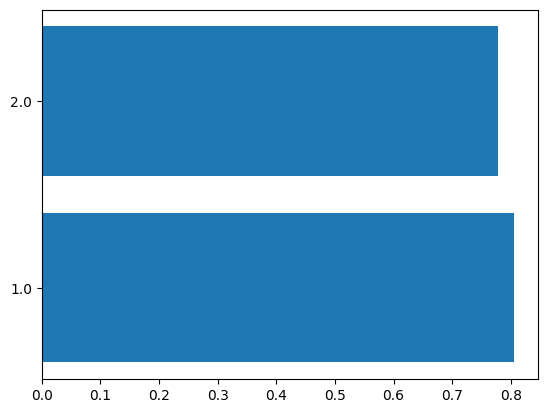

In [13]:
comparaison_chart(grid_search_svc_classifier)


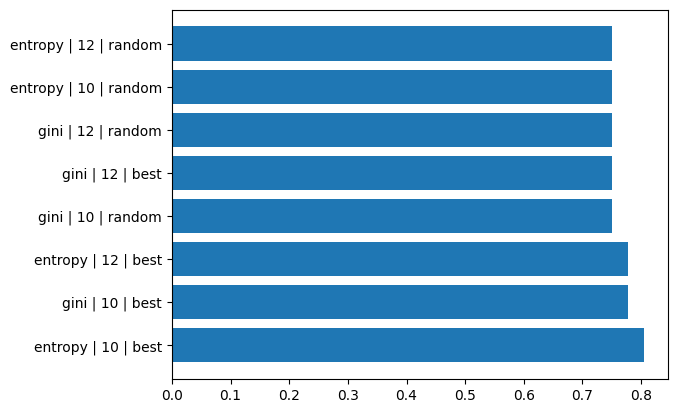

In [14]:
comparaison_chart(grid_search_decision_tree_classifier)


,svc_classifier,decision_tree_classifier
f1_score,0.000000,0.222222
auc,0.459459,0.551351


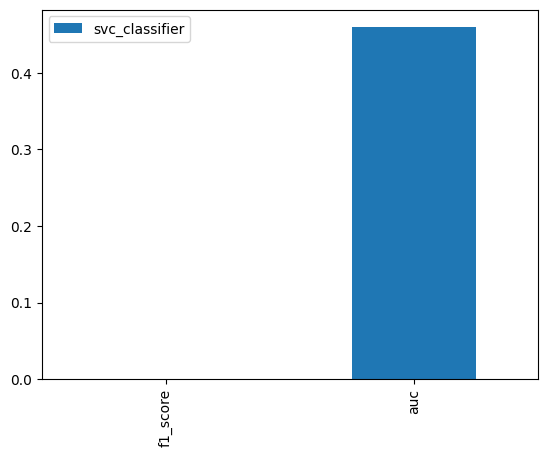

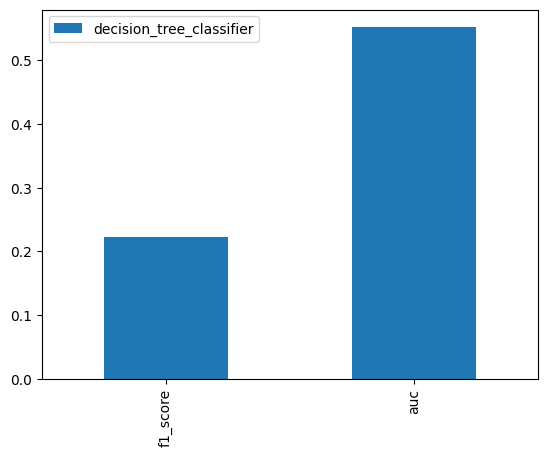

In [15]:
scores = {}
y_test_format = y_test.to_numpy()
y_test_format = np.array(np.where(y_test_format == "no", 0, 1), dtype=int)
prediction = grid_search_svc_classifier.predict(X_test)
prediction = np.array(np.where(prediction == "no", 0, 1), dtype=int)
scores["svc_classifier"] = {}

scores["svc_classifier"]["f1_score"] = f1_score(y_test_format, prediction)

scores["svc_classifier"]["auc"] = roc_auc_score(y_test_format, prediction)

prediction = grid_search_decision_tree_classifier.predict(X_test)
prediction = np.array(np.where(prediction == "no", 0, 1), dtype=int)
scores["decision_tree_classifier"] = {}

scores["decision_tree_classifier"]["f1_score"] = f1_score(y_test_format, prediction)

scores["decision_tree_classifier"]["auc"] = roc_auc_score(y_test_format, prediction)

plot_df = pd.DataFrame(scores)
for cls in ['svc_classifier', 'decision_tree_classifier']:
	plot_df.plot(y=cls, kind="bar", use_index=True)
plot_df
